Here we will build a connectivity analysis pipeline for the KPE study. 
Methods should be easily generalized for others studies. 


In [9]:
## Use this box if you want MDSL
# using MSDL atlas - Can choose different atlas or different nodes (using ICA or something else)
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()

# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
#labels_img=yeo['thick_17']
labels =  atlas['labels']
coords = atlas.region_coords# grab center coordinates for atlas labels
#coords = plotting.find_parcellation_cut_coords(labels_img=labels)
#atlas.region_coords

# optional set of different atlas
#atlas_yeo_2011 = 
#atlas_yeo = atlas_yeo_2011.thick_7

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [132]:
labels

['L Aud',
 'R Aud',
 'Striate',
 'L DMN',
 'Med DMN',
 'Front DMN',
 'R DMN',
 'Occ post',
 'Motor',
 'R DLPFC',
 'R Front pol',
 'R Par',
 'R Post Temp',
 'Basal',
 'L Par',
 'L DLPFC',
 'L Front pol',
 'L IPS',
 'R IPS',
 'L LOC',
 'Vis',
 'R LOC',
 'D ACC',
 'V ACC',
 'R A Ins',
 'L STS',
 'R STS',
 'L TPJ',
 'Broca',
 'Sup Front S',
 'R TPJ',
 'R Pars Op',
 'Cereb',
 'Dors PCC',
 'L Ins',
 'Cing',
 'R Ins',
 'L Ant IPS',
 'R Ant IPS']

In [8]:
# Run either this or MSDL - not both boxes
# try to use Shen atlas
import pandas as pd

atlas_filename = '/home/oad4/nilearn_data/shenParcellation/shen_2mm_268_parcellation.nii.gz'
atlas_labes = pd.read_csv('/home/oad4/nilearn_data/shenParcellation/shen_268_parcellation_networklabels.csv')
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

atlas_labes = np.array(atlas_labes)
atlas_labes

NameError: name 'plotting' is not defined

In [10]:
import os
import numpy as np

In [11]:
# methods
def removeVars (confoundFile):
    # this method takes the csv regressors file (from fmriPrep) and chooses a few to confound. You can change those few
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf', 'white_matter', 'framewise_displacement',
                          'a_comp_cor_00', 'a_comp_cor_01',	'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 
                        'a_comp_cor_05', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']] # can add 'global_signal' also
     # change NaN of FD to zero
    finalConf = np.array(finalConf)
    finalConf[0,2] = 0
    return finalConf

In [12]:
# build method for creating time series for subjects
def timeSeries(func_files, confound_files):
    total_subjects = [] # creating an empty array that will hold all subjects matrix 
    # This function needs a masker object that will be defined outside the function
    for func_file, confound_file in zip(func_files, confound_files):
        confoundClean = removeVars(confound_file)
        confoundArray = confoundClean#confoundClean.values
        time_series = masker.fit_transform(func_file, confounds=confoundArray)
        #time_series = extractor.fit_transform(func_file, confounds=confoundArray)
        #masker.fit_transform(func_file, confoundArray)
        total_subjects.append(time_series)
    return total_subjects

# contrasting two timePoints
def contFuncs(time_series1, time_series2):
    twoMinusOneMat = []
    for scanMatrix, scanMatrix2 in zip(time_series1, time_series2):
        a = scanMatrix2 - scanMatrix
        twoMinusOneMat.append(a)
    return np.array(twoMinusOneMat)

import numpy as np
from nilearn import plotting

# create correlation matrix per subject
def createCorMat(time_series):
    # create correlation matrix for each subject
    fullMatrix = []
    for time_s in time_series:
        correlation_matrix = correlation_measure.fit_transform([time_s])[0]
        fullMatrix.append(correlation_matrix)
    return fullMatrix

# create connecotme graph per subject
def connectome_graph (fullMatrix):
    # here it is set to threshold 1%
    for matrix in fullMatrix:
        plotting.plot_connectome(matrix, coords,
                             edge_threshold="99%", colorbar=True)
        plotting.show()

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [14]:
# Here you set the specific methods for masking and correlation. Please see Nilearn website for more info.

from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
# in this mask we standardize the values, so mean is 0 and between -1 to 1
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, smoothing_fwhm = 6,
                         memory="/home/oad4/scratch60/nilearn",high_pass=.01 , low_pass = .1, t_r=1, verbose=5)

# use different masker when using Yeo atlas. 
#masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,smoothing_fwhm = 6,
 #                        memory="/home/oad4/scratch60/nilearn",high_pass=.01 , low_pass = .1, t_r=1, verbose=5)
                           
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='partial correlation') # can choose partial - it might be better


In [15]:
# now we call subjcets
# and start the real analysis
subList =  ['008','1293','1307','1322','1339','1343','1387','1223']
midSubList = ['1253','1263','1351','1364','1369','1390','1403']

# these two functions take subject list and session number (in string) and return func file list and confound file list
def fileList(subjects, session):
    func_files = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (sub,session,sub,session) for sub in subjects]
    return func_files

def confList(subjects, session):
    confound_files = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_desc-confounds_regressors.tsv' % (sub,session,sub,session) for sub in subjects]
    return confound_files


In [19]:
# now we call for the functions for each set.
# for every time line we want to run time series and then contrast between the times
ket1_series = timeSeries(func_files=fileList(subList,'1'), confound_files=confList(subList, '1'))

[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[Memory]0.1s, 0.0min    : Loading resample_img...


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/home/oad4/scratch60/nilearn'", use "location='/home/oad4/scratch60/nilearn'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:302: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is curre

________________________________________resample_img cache loaded - 3.0s, 0.1min
[Memory]3.8s, 0.1min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/oad4/scratch60/kpeOutput/fmriprep/sub-1293/ses-1/func/sub-1293_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'maps_img': '/home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'smoothing_fwhm': 6,
  'standardize': True,
  't_r': 1,
  'target_affine': None,
  'target_shape': None}, confounds=array([[5.097043e+03, ..., 3.275410e-04],
       ...,
       [4.979917e+03, ..., 3.776370e-03]]), dtype=None, memory=Memory(location=/home/oad4/scratch60/nilearn/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from /home/oad4/scratch60/kpeOutput/fmriprep/sub-1293/ses-1/func/sub-1293_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-pr

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/input_data/nifti_maps_masker.py:326: UserWarning: Persisting input arguments took 1.18s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


______________________________________________filter_and_extract - 88.1s, 1.5min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]119.7s, 2.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]131.5s, 2.2min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]143.7s, 2.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]156.7s, 2.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]169.6s, 2.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]182.3s, 3.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [20]:
ket2_series = timeSeries(func_files=fileList(subList,'2'), confound_files=confList(subList, '2'))

[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]195.2s, 3.3min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]208.5s, 3.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]221.6s, 3.7min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]234.3s, 3.9min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]246.4s, 4.1min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]260.1s, 4.3min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]273.0s, 4.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]285.5s, 4.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [21]:
ket3_series = timeSeries(func_files=fileList(subList,'3'), confound_files=confList(subList, '3'))

[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]298.8s, 5.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]311.5s, 5.2min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]324.6s, 5.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]336.2s, 5.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]348.5s, 5.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]361.9s, 6.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]375.4s, 6.3min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]387.8s, 6.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [22]:
# build correlation matrix for each time point
ket1_corr = createCorMat(time_series=ket1_series)
ket2_corr = createCorMat(ket2_series)
ket3_corr = createCorMat(ket3_series)

In [23]:
# start contrasting
ket2_ket1 = contFuncs(ket1_corr, ket2_corr)
ket3_ket1 = contFuncs(ket1_corr, ket3_corr)
#ket3_ket1 = np.average(ket3_corr, axis=0) - np.average(ket1_corr, axis = 0) # we do so because the number do not match

ket3_ket1.shape


(8, 39, 39)

In [24]:
plotting.plot_connectome(np.average(ket2_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 7days minux first")

plotting.plot_connectome(np.average(ket3_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 30days minux first")



In [25]:
# let do midazolam
mid1_series = timeSeries(func_files=fileList(midSubList,'1'), confound_files=confList(midSubList, '1'))

mid2_series = timeSeries(func_files=fileList(midSubList,'2'), confound_files=confList(midSubList, '2'))

[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/oad4/scratch60/kpeOutput/fmriprep/sub-1253/ses-1/func/sub-1253_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'maps_img': '/home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'smoothing_fwhm': 6,
  'standardize': True,
  't_r': 1,
  'target_affine': None,
  'target_shape': None}, confounds=array([[6466.359068, ...,    0.      ],
       ...,
       [6357.153265, ...,    0.      ]]), dtype=None, memory=Memory(location=/home/oad4/scratch60/nilearn/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from /home/oad4/scratch60/kpeOutput/fmriprep/sub-1253/ses-1/func/sub-1253_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-prepro

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/input_data/nifti_maps_masker.py:326: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


______________________________________________filter_and_extract - 92.0s, 1.5min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]509.9s, 8.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]526.3s, 8.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]541.2s, 9.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]554.3s, 9.2min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]567.4s, 9.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]579.7s, 9.7min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]593.5s, 9.9min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]606.2s, 10.1min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]619.1s, 10.3min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]631.9s, 10.5min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]644.4s, 10.7min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]657.6s, 11.0min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]670.9s, 11.2min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.7s, 0.0min


In [26]:
mid3_no1253 = midSubList
print(mid3_no1253)
mid3_no1253.remove('1253')
mid3_series = timeSeries(fileList(mid3_no1253,'3'), confList(mid3_no1253,'3'))

['1253', '1263', '1351', '1364', '1369', '1390', '1403']
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]689.8s, 11.5min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]704.3s, 11.7min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]718.3s, 12.0min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]731.2s, 12.2min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]747.6s, 12.5min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]765.7s, 12.8min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


In [29]:
# build correlation matrix for each time point
mid1_corr = createCorMat(time_series=mid1_series)
mid2_corr = createCorMat(mid2_series)
mid3_corr = createCorMat(mid3_series)

In [30]:
# start contrasting
mid2_mid1 = contFuncs(mid1_corr, mid2_corr)
ket3_ket1 = contFuncs(ket1_corr, ket3_corr)

#mid3_mid1 = np.average(mid3_corr, axis=0) - np.average(mid1_corr, axis = 0) # we do so because the number do not match

#mid3_mid1.shape


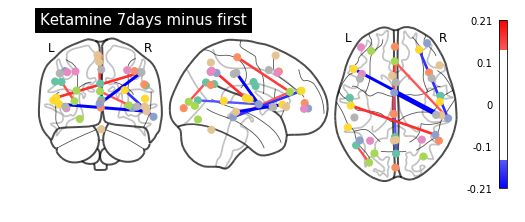

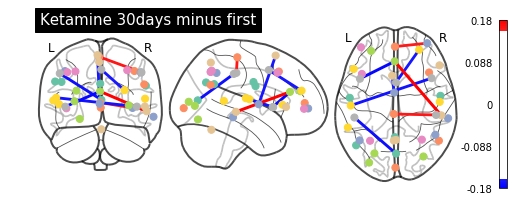

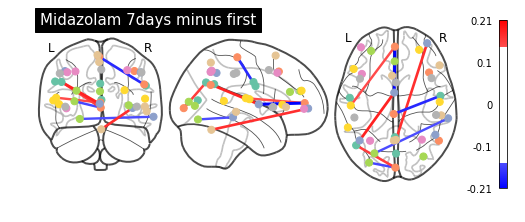

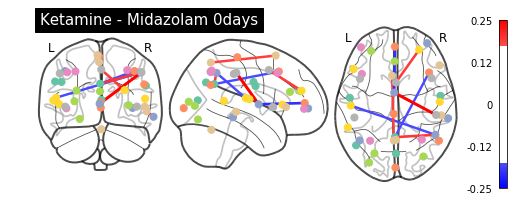

In [37]:
%matplotlib inline

plotting.plot_connectome(np.average(ket2_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 7days minus first")

plotting.plot_connectome(np.average(ket3_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 30days minus first")

plotting.plot_connectome(np.average(mid2_mid1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Midazolam 7days minus first")

#plotting.plot_connectome(mid3_mid1, coords,
 #                        edge_threshold="99%", colorbar=True, title = "midazolam 30days minux first")

plotting.plot_connectome(np.average(ket1_corr,axis=0) -np.average(mid1_corr, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine - Midazolam 0days")

plotting.plot_connectome(np.average(ket2_corr,axis=0)-np.average(mid2_corr,axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine-Midazolan 7days", output_file='pretty_brain.png')


plotting.show()


In [34]:
# rearrange the array to N,N,subnumber for NBS
ket1Reshape = np.moveaxis(np.array(ket1_corr), 0,-1)
print(ket1Reshape.shape)
ket2Reshape = np.moveaxis(np.array(ket2_corr), 0,-1)
ket3Reshape = np.moveaxis(np.array(ket3_corr), 0,-1)
mid1Reshape = np.moveaxis(np.array(mid1_corr),0,-1)
mid2Reshape = np.moveaxis(np.array(mid2_corr),0,-1)
mid3Reshape = np.moveaxis(np.array(mid3_corr),0,-1)

print(mid3Reshape.shape)


(39, 39, 8)
(39, 39, 6)


In [154]:
# now we can run NBS
# NBS is taken from: https://github.com/aestrivex/bctpy, can be installed using pip (pip install bctpy)
from bct import nbs
pval, adj, _ = nbs.nbs_bct(ket1Reshape, ket3Reshape, thresh=2.5, tail='both',k=1500, paired=True, verbose = True)
# check mean p vlue
#np.mean(checkNBS[0])

max component size is 39
estimating null distribution with 1500 permutations
permutation 0 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 1 of 1500.  Permutation max is 15.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 2 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 3 of 1500.  Permutation max is 29.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 4 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 5 of 1500.  Permutation max is 33.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 6 of 1500.  Permutation max is 7.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 7 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 8 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 9 of 1500.  Permutation max is 36.0.  O

permutation 84 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 85 of 1500.  Permutation max is 21.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 86 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 87 of 1500.  Permutation max is 29.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 88 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 89 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 90 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 91 of 1500.  Permutation max is 7.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 92 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 93 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 94 of 150

permutation 168 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.030
permutation 169 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.029
permutation 170 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.029
permutation 171 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.029
permutation 172 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.029
permutation 173 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.029
permutation 174 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.034
permutation 175 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.034
permutation 176 of 1500.  Permutation max is 8.0.  Observed max is 39.0.  P-val estimate is 0.034
permutation 177 of 1500.  Permutation max is 33.0.  Observed max is 39.0.  P-val estimate is 0.034
permutation

permutation 252 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.036
permutation 253 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.039
permutation 254 of 1500.  Permutation max is 35.0.  Observed max is 39.0.  P-val estimate is 0.039
permutation 255 of 1500.  Permutation max is 38.0.  Observed max is 39.0.  P-val estimate is 0.039
permutation 256 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.039
permutation 257 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.039
permutation 258 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.039
permutation 259 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.038
permutation 260 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.038
permutation 261 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.038
permutatio

permutation 336 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.042
permutation 337 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 338 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 339 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 340 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 341 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 342 of 1500.  Permutation max is 29.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 343 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 344 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 345 of 1500.  Permutation max is 8.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation

permutation 420 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation 421 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation 422 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation 423 of 1500.  Permutation max is 11.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation 424 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation 425 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation 426 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation 427 of 1500.  Permutation max is 39.0.  Observed max is 39.0.  P-val estimate is 0.042
permutation 428 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.042
permutation 429 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.042
permutatio

permutation 504 of 1500.  Permutation max is 36.0.  Observed max is 39.0.  P-val estimate is 0.042
permutation 505 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 506 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 507 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 508 of 1500.  Permutation max is 19.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 509 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 510 of 1500.  Permutation max is 11.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 511 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 512 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 513 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.045
permutatio

permutation 588 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 589 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 590 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 591 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 592 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 593 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 594 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 595 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 596 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 597 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.050
permutatio

permutation 672 of 1500.  Permutation max is 15.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 673 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 674 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 675 of 1500.  Permutation max is 32.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 676 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 677 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 678 of 1500.  Permutation max is 12.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 679 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 680 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 681 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.051
permutatio

permutation 756 of 1500.  Permutation max is 21.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 757 of 1500.  Permutation max is 12.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 758 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 759 of 1500.  Permutation max is 36.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 760 of 1500.  Permutation max is 45.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 761 of 1500.  Permutation max is 19.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 762 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 763 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 764 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 765 of 1500.  Permutation max is 6.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation

permutation 839 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 840 of 1500.  Permutation max is 7.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 841 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 842 of 1500.  Permutation max is 33.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 843 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 844 of 1500.  Permutation max is 33.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 845 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 846 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 847 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 848 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation

permutation 926 of 1500.  Permutation max is 29.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 927 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 928 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 929 of 1500.  Permutation max is 38.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 930 of 1500.  Permutation max is 19.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 931 of 1500.  Permutation max is 8.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 932 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 933 of 1500.  Permutation max is 7.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 934 of 1500.  Permutation max is 19.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 935 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 

permutation 1012 of 1500.  Permutation max is 12.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 1013 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 1014 of 1500.  Permutation max is 39.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1015 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1016 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1017 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1018 of 1500.  Permutation max is 12.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1019 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1020 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1021 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.048


permutation 1097 of 1500.  Permutation max is 8.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1098 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1099 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1100 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1101 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1102 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1103 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1104 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1105 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1106 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.048
p

permutation 1182 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.046
permutation 1183 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.046
permutation 1184 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.046
permutation 1185 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.046
permutation 1186 of 1500.  Permutation max is 6.0.  Observed max is 39.0.  P-val estimate is 0.046
permutation 1187 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 1188 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 1189 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 1190 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.047
permutation 1191 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.047
p

permutation 1266 of 1500.  Permutation max is 32.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 1267 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 1268 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 1269 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 1270 of 1500.  Permutation max is 29.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 1271 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 1272 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1273 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1274 of 1500.  Permutation max is 12.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1275 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.049


permutation 1352 of 1500.  Permutation max is 27.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 1353 of 1500.  Permutation max is 29.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1354 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1355 of 1500.  Permutation max is 37.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1356 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1357 of 1500.  Permutation max is 33.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1358 of 1500.  Permutation max is 9.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1359 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1360 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.050
permutation 1361 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.050
p

permutation 1435 of 1500.  Permutation max is 19.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1436 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1437 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1438 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1439 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1440 of 1500.  Permutation max is 21.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1441 of 1500.  Permutation max is 15.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1442 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.049
permutation 1443 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.048
permutation 1444 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.048


In [158]:
print(pval.shape)
print (pval)
len(pval)
print(adj.shape)
import bct

#bct.adjacency_plot_und(adj, coords, tube=False)

(1,)
[0.04733333]
(39, 39)


Between 30 days in 1st day Ketamine has different in one components. 
Lets graph it

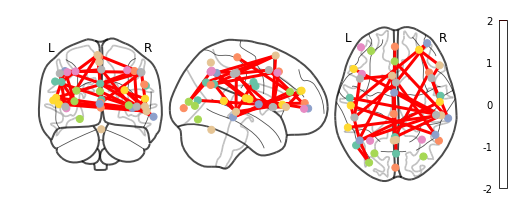

In [139]:
# look at the specific nodes that are components
plotting.plot_connectome(adj, coords,
                         edge_threshold="99.5%", colorbar=True)

In [134]:
view_all = plotting.view_connectome(np.array(ketDeltaA), coords, threshold='95%')
#viewb
view_all



In [108]:
# Lets check Midazolam group


(39, 39, 8)

In [63]:
pvalMid, adjMid, _ = nbs.nbs_bct(mid1Reshape[:,:,:6], mid3Reshape, thresh=2.5, tail='both',k=1000, paired=True, verbose = True)


max component size is 36
estimating null distribution with 1000 permutations
permutation 0 of 1000.  Permutation max is 28.0.  Observed max is 36.0.  P-val estimate is 0.000
permutation 1 of 1000.  Permutation max is 34.0.  Observed max is 36.0.  P-val estimate is 0.000
permutation 2 of 1000.  Permutation max is 30.0.  Observed max is 36.0.  P-val estimate is 0.000
permutation 3 of 1000.  Permutation max is 28.0.  Observed max is 36.0.  P-val estimate is 0.000
permutation 4 of 1000.  Permutation max is 25.0.  Observed max is 36.0.  P-val estimate is 0.000
permutation 5 of 1000.  Permutation max is 40.0.  Observed max is 36.0.  P-val estimate is 0.167
permutation 6 of 1000.  Permutation max is 34.0.  Observed max is 36.0.  P-val estimate is 0.143
permutation 7 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.250
permutation 8 of 1000.  Permutation max is 45.0.  Observed max is 36.0.  P-val estimate is 0.333
permutation 9 of 1000.  Permutation max is 58.0.  

permutation 83 of 1000.  Permutation max is 45.0.  Observed max is 36.0.  P-val estimate is 0.393
permutation 84 of 1000.  Permutation max is 34.0.  Observed max is 36.0.  P-val estimate is 0.388
permutation 85 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.384
permutation 86 of 1000.  Permutation max is 36.0.  Observed max is 36.0.  P-val estimate is 0.391
permutation 87 of 1000.  Permutation max is 29.0.  Observed max is 36.0.  P-val estimate is 0.386
permutation 88 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.393
permutation 89 of 1000.  Permutation max is 42.0.  Observed max is 36.0.  P-val estimate is 0.400
permutation 90 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.407
permutation 91 of 1000.  Permutation max is 25.0.  Observed max is 36.0.  P-val estimate is 0.402
permutation 92 of 1000.  Permutation max is 41.0.  Observed max is 36.0.  P-val estimate is 0.409
permutation 93 of 10

permutation 167 of 1000.  Permutation max is 27.0.  Observed max is 36.0.  P-val estimate is 0.446
permutation 168 of 1000.  Permutation max is 30.0.  Observed max is 36.0.  P-val estimate is 0.444
permutation 169 of 1000.  Permutation max is 28.0.  Observed max is 36.0.  P-val estimate is 0.441
permutation 170 of 1000.  Permutation max is 34.0.  Observed max is 36.0.  P-val estimate is 0.439
permutation 171 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.442
permutation 172 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.445
permutation 173 of 1000.  Permutation max is 34.0.  Observed max is 36.0.  P-val estimate is 0.443
permutation 174 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.446
permutation 175 of 1000.  Permutation max is 43.0.  Observed max is 36.0.  P-val estimate is 0.449
permutation 176 of 1000.  Permutation max is 20.0.  Observed max is 36.0.  P-val estimate is 0.446
permutatio

permutation 253 of 1000.  Permutation max is 27.0.  Observed max is 36.0.  P-val estimate is 0.457
permutation 254 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.455
permutation 255 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.457
permutation 256 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.459
permutation 257 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.457
permutation 258 of 1000.  Permutation max is 40.0.  Observed max is 36.0.  P-val estimate is 0.459
permutation 259 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.462
permutation 260 of 1000.  Permutation max is 50.0.  Observed max is 36.0.  P-val estimate is 0.464
permutation 261 of 1000.  Permutation max is 27.0.  Observed max is 36.0.  P-val estimate is 0.462
permutation 262 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.464
permutatio

permutation 338 of 1000.  Permutation max is 55.0.  Observed max is 36.0.  P-val estimate is 0.484
permutation 339 of 1000.  Permutation max is 32.0.  Observed max is 36.0.  P-val estimate is 0.482
permutation 340 of 1000.  Permutation max is 29.0.  Observed max is 36.0.  P-val estimate is 0.481
permutation 341 of 1000.  Permutation max is 37.0.  Observed max is 36.0.  P-val estimate is 0.482
permutation 342 of 1000.  Permutation max is 28.0.  Observed max is 36.0.  P-val estimate is 0.481
permutation 343 of 1000.  Permutation max is 34.0.  Observed max is 36.0.  P-val estimate is 0.480
permutation 344 of 1000.  Permutation max is 36.0.  Observed max is 36.0.  P-val estimate is 0.481
permutation 345 of 1000.  Permutation max is 40.0.  Observed max is 36.0.  P-val estimate is 0.483
permutation 346 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.484
permutation 347 of 1000.  Permutation max is 46.0.  Observed max is 36.0.  P-val estimate is 0.486
permutatio

permutation 422 of 1000.  Permutation max is 40.0.  Observed max is 36.0.  P-val estimate is 0.487
permutation 423 of 1000.  Permutation max is 50.0.  Observed max is 36.0.  P-val estimate is 0.488
permutation 424 of 1000.  Permutation max is 25.0.  Observed max is 36.0.  P-val estimate is 0.487
permutation 425 of 1000.  Permutation max is 32.0.  Observed max is 36.0.  P-val estimate is 0.486
permutation 426 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.485
permutation 427 of 1000.  Permutation max is 37.0.  Observed max is 36.0.  P-val estimate is 0.486
permutation 428 of 1000.  Permutation max is 20.0.  Observed max is 36.0.  P-val estimate is 0.485
permutation 429 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.484
permutation 430 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.485
permutation 431 of 1000.  Permutation max is 33.0.  Observed max is 36.0.  P-val estimate is 0.484
permutatio

permutation 506 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.493
permutation 507 of 1000.  Permutation max is 25.0.  Observed max is 36.0.  P-val estimate is 0.492
permutation 508 of 1000.  Permutation max is 40.0.  Observed max is 36.0.  P-val estimate is 0.493
permutation 509 of 1000.  Permutation max is 50.0.  Observed max is 36.0.  P-val estimate is 0.494
permutation 510 of 1000.  Permutation max is 25.0.  Observed max is 36.0.  P-val estimate is 0.493
permutation 511 of 1000.  Permutation max is 25.0.  Observed max is 36.0.  P-val estimate is 0.492
permutation 512 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.491
permutation 513 of 1000.  Permutation max is 50.0.  Observed max is 36.0.  P-val estimate is 0.492
permutation 514 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.493
permutation 515 of 1000.  Permutation max is 16.0.  Observed max is 36.0.  P-val estimate is 0.492
permutatio

permutation 592 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.501
permutation 593 of 1000.  Permutation max is 20.0.  Observed max is 36.0.  P-val estimate is 0.500
permutation 594 of 1000.  Permutation max is 27.0.  Observed max is 36.0.  P-val estimate is 0.499
permutation 595 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.500
permutation 596 of 1000.  Permutation max is 53.0.  Observed max is 36.0.  P-val estimate is 0.501
permutation 597 of 1000.  Permutation max is 32.0.  Observed max is 36.0.  P-val estimate is 0.500
permutation 598 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.501
permutation 599 of 1000.  Permutation max is 42.0.  Observed max is 36.0.  P-val estimate is 0.502
permutation 600 of 1000.  Permutation max is 53.0.  Observed max is 36.0.  P-val estimate is 0.502
permutation 601 of 1000.  Permutation max is 34.0.  Observed max is 36.0.  P-val estimate is 0.502
permutatio

permutation 675 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.494
permutation 676 of 1000.  Permutation max is 57.0.  Observed max is 36.0.  P-val estimate is 0.495
permutation 677 of 1000.  Permutation max is 19.0.  Observed max is 36.0.  P-val estimate is 0.494
permutation 678 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.495
permutation 679 of 1000.  Permutation max is 37.0.  Observed max is 36.0.  P-val estimate is 0.496
permutation 680 of 1000.  Permutation max is 33.0.  Observed max is 36.0.  P-val estimate is 0.495
permutation 681 of 1000.  Permutation max is 50.0.  Observed max is 36.0.  P-val estimate is 0.496
permutation 682 of 1000.  Permutation max is 43.0.  Observed max is 36.0.  P-val estimate is 0.496
permutation 683 of 1000.  Permutation max is 25.0.  Observed max is 36.0.  P-val estimate is 0.496
permutation 684 of 1000.  Permutation max is 28.0.  Observed max is 36.0.  P-val estimate is 0.495
permutatio

permutation 760 of 1000.  Permutation max is 50.0.  Observed max is 36.0.  P-val estimate is 0.490
permutation 761 of 1000.  Permutation max is 36.0.  Observed max is 36.0.  P-val estimate is 0.491
permutation 762 of 1000.  Permutation max is 42.0.  Observed max is 36.0.  P-val estimate is 0.491
permutation 763 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.492
permutation 764 of 1000.  Permutation max is 16.0.  Observed max is 36.0.  P-val estimate is 0.492
permutation 765 of 1000.  Permutation max is 32.0.  Observed max is 36.0.  P-val estimate is 0.491
permutation 766 of 1000.  Permutation max is 50.0.  Observed max is 36.0.  P-val estimate is 0.492
permutation 767 of 1000.  Permutation max is 33.0.  Observed max is 36.0.  P-val estimate is 0.491
permutation 768 of 1000.  Permutation max is 29.0.  Observed max is 36.0.  P-val estimate is 0.490
permutation 769 of 1000.  Permutation max is 57.0.  Observed max is 36.0.  P-val estimate is 0.491
permutatio

permutation 844 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.486
permutation 845 of 1000.  Permutation max is 43.0.  Observed max is 36.0.  P-val estimate is 0.487
permutation 846 of 1000.  Permutation max is 41.0.  Observed max is 36.0.  P-val estimate is 0.488
permutation 847 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.488
permutation 848 of 1000.  Permutation max is 25.0.  Observed max is 36.0.  P-val estimate is 0.488
permutation 849 of 1000.  Permutation max is 53.0.  Observed max is 36.0.  P-val estimate is 0.488
permutation 850 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.489
permutation 851 of 1000.  Permutation max is 35.0.  Observed max is 36.0.  P-val estimate is 0.488
permutation 852 of 1000.  Permutation max is 45.0.  Observed max is 36.0.  P-val estimate is 0.489
permutation 853 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.489
permutatio

permutation 932 of 1000.  Permutation max is 43.0.  Observed max is 36.0.  P-val estimate is 0.492
permutation 933 of 1000.  Permutation max is 45.0.  Observed max is 36.0.  P-val estimate is 0.493
permutation 934 of 1000.  Permutation max is 41.0.  Observed max is 36.0.  P-val estimate is 0.493
permutation 935 of 1000.  Permutation max is 47.0.  Observed max is 36.0.  P-val estimate is 0.494
permutation 936 of 1000.  Permutation max is 42.0.  Observed max is 36.0.  P-val estimate is 0.494
permutation 937 of 1000.  Permutation max is 27.0.  Observed max is 36.0.  P-val estimate is 0.494
permutation 938 of 1000.  Permutation max is 57.0.  Observed max is 36.0.  P-val estimate is 0.494
permutation 939 of 1000.  Permutation max is 42.0.  Observed max is 36.0.  P-val estimate is 0.495
permutation 940 of 1000.  Permutation max is 57.0.  Observed max is 36.0.  P-val estimate is 0.495
permutation 941 of 1000.  Permutation max is 58.0.  Observed max is 36.0.  P-val estimate is 0.496
permutatio

In [64]:
print(pvalMid.shape)
print (pvalMid)

(2,)
[1.    0.496]


Midazolam has no significant change between first day and 7 or 30 days.
Lets check differences between ket and mid.

In [67]:
pvalKetMid, adjKetMid, _ = nbs.nbs_bct(ket2Reshape, mid2Reshape, thresh=2.5, tail='both',k=1000, paired=False, verbose = True)


max component size is 13
estimating null distribution with 1000 permutations
permutation 0 of 1000.  Permutation max is 4.0.  Observed max is 13.0.  P-val estimate is 0.000
permutation 1 of 1000.  Permutation max is 21.0.  Observed max is 13.0.  P-val estimate is 0.500
permutation 2 of 1000.  Permutation max is 4.0.  Observed max is 13.0.  P-val estimate is 0.333
permutation 3 of 1000.  Permutation max is 17.0.  Observed max is 13.0.  P-val estimate is 0.500
permutation 4 of 1000.  Permutation max is 15.0.  Observed max is 13.0.  P-val estimate is 0.600
permutation 5 of 1000.  Permutation max is 6.0.  Observed max is 13.0.  P-val estimate is 0.500
permutation 6 of 1000.  Permutation max is 14.0.  Observed max is 13.0.  P-val estimate is 0.571
permutation 7 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.500
permutation 8 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.444
permutation 9 of 1000.  Permutation max is 9.0.  Observ

permutation 85 of 1000.  Permutation max is 29.0.  Observed max is 13.0.  P-val estimate is 0.326
permutation 86 of 1000.  Permutation max is 15.0.  Observed max is 13.0.  P-val estimate is 0.333
permutation 87 of 1000.  Permutation max is 18.0.  Observed max is 13.0.  P-val estimate is 0.341
permutation 88 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.337
permutation 89 of 1000.  Permutation max is 3.0.  Observed max is 13.0.  P-val estimate is 0.333
permutation 90 of 1000.  Permutation max is 8.0.  Observed max is 13.0.  P-val estimate is 0.330
permutation 91 of 1000.  Permutation max is 9.0.  Observed max is 13.0.  P-val estimate is 0.326
permutation 92 of 1000.  Permutation max is 9.0.  Observed max is 13.0.  P-val estimate is 0.323
permutation 93 of 1000.  Permutation max is 7.0.  Observed max is 13.0.  P-val estimate is 0.319
permutation 94 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.316
permutation 95 of 1000.  P

permutation 169 of 1000.  Permutation max is 17.0.  Observed max is 13.0.  P-val estimate is 0.347
permutation 170 of 1000.  Permutation max is 17.0.  Observed max is 13.0.  P-val estimate is 0.351
permutation 171 of 1000.  Permutation max is 4.0.  Observed max is 13.0.  P-val estimate is 0.349
permutation 172 of 1000.  Permutation max is 14.0.  Observed max is 13.0.  P-val estimate is 0.353
permutation 173 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.351
permutation 174 of 1000.  Permutation max is 7.0.  Observed max is 13.0.  P-val estimate is 0.349
permutation 175 of 1000.  Permutation max is 12.0.  Observed max is 13.0.  P-val estimate is 0.347
permutation 176 of 1000.  Permutation max is 17.0.  Observed max is 13.0.  P-val estimate is 0.350
permutation 177 of 1000.  Permutation max is 6.0.  Observed max is 13.0.  P-val estimate is 0.348
permutation 178 of 1000.  Permutation max is 6.0.  Observed max is 13.0.  P-val estimate is 0.346
permutation 17

permutation 253 of 1000.  Permutation max is 7.0.  Observed max is 13.0.  P-val estimate is 0.378
permutation 254 of 1000.  Permutation max is 9.0.  Observed max is 13.0.  P-val estimate is 0.376
permutation 255 of 1000.  Permutation max is 7.0.  Observed max is 13.0.  P-val estimate is 0.375
permutation 256 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.374
permutation 257 of 1000.  Permutation max is 16.0.  Observed max is 13.0.  P-val estimate is 0.376
permutation 258 of 1000.  Permutation max is 25.0.  Observed max is 13.0.  P-val estimate is 0.378
permutation 259 of 1000.  Permutation max is 7.0.  Observed max is 13.0.  P-val estimate is 0.377
permutation 260 of 1000.  Permutation max is 8.0.  Observed max is 13.0.  P-val estimate is 0.375
permutation 261 of 1000.  Permutation max is 13.0.  Observed max is 13.0.  P-val estimate is 0.378
permutation 262 of 1000.  Permutation max is 13.0.  Observed max is 13.0.  P-val estimate is 0.380
permutation 263 

permutation 337 of 1000.  Permutation max is 8.0.  Observed max is 13.0.  P-val estimate is 0.367
permutation 338 of 1000.  Permutation max is 16.0.  Observed max is 13.0.  P-val estimate is 0.369
permutation 339 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.368
permutation 340 of 1000.  Permutation max is 9.0.  Observed max is 13.0.  P-val estimate is 0.367
permutation 341 of 1000.  Permutation max is 4.0.  Observed max is 13.0.  P-val estimate is 0.365
permutation 342 of 1000.  Permutation max is 3.0.  Observed max is 13.0.  P-val estimate is 0.364
permutation 343 of 1000.  Permutation max is 8.0.  Observed max is 13.0.  P-val estimate is 0.363
permutation 344 of 1000.  Permutation max is 18.0.  Observed max is 13.0.  P-val estimate is 0.365
permutation 345 of 1000.  Permutation max is 25.0.  Observed max is 13.0.  P-val estimate is 0.367
permutation 346 of 1000.  Permutation max is 16.0.  Observed max is 13.0.  P-val estimate is 0.369
permutation 347 

permutation 421 of 1000.  Permutation max is 7.0.  Observed max is 13.0.  P-val estimate is 0.377
permutation 422 of 1000.  Permutation max is 4.0.  Observed max is 13.0.  P-val estimate is 0.376
permutation 423 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.375
permutation 424 of 1000.  Permutation max is 6.0.  Observed max is 13.0.  P-val estimate is 0.374
permutation 425 of 1000.  Permutation max is 13.0.  Observed max is 13.0.  P-val estimate is 0.376
permutation 426 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.375
permutation 427 of 1000.  Permutation max is 3.0.  Observed max is 13.0.  P-val estimate is 0.374
permutation 428 of 1000.  Permutation max is 15.0.  Observed max is 13.0.  P-val estimate is 0.375
permutation 429 of 1000.  Permutation max is 6.0.  Observed max is 13.0.  P-val estimate is 0.374
permutation 430 of 1000.  Permutation max is 17.0.  Observed max is 13.0.  P-val estimate is 0.376
permutation 431 o

permutation 505 of 1000.  Permutation max is 13.0.  Observed max is 13.0.  P-val estimate is 0.393
permutation 506 of 1000.  Permutation max is 27.0.  Observed max is 13.0.  P-val estimate is 0.394
permutation 507 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.394
permutation 508 of 1000.  Permutation max is 8.0.  Observed max is 13.0.  P-val estimate is 0.393
permutation 509 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.392
permutation 510 of 1000.  Permutation max is 12.0.  Observed max is 13.0.  P-val estimate is 0.391
permutation 511 of 1000.  Permutation max is 6.0.  Observed max is 13.0.  P-val estimate is 0.391
permutation 512 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.390
permutation 513 of 1000.  Permutation max is 4.0.  Observed max is 13.0.  P-val estimate is 0.389
permutation 514 of 1000.  Permutation max is 12.0.  Observed max is 13.0.  P-val estimate is 0.388
permutation 51

permutation 589 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.400
permutation 590 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.399
permutation 591 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.399
permutation 592 of 1000.  Permutation max is 9.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 593 of 1000.  Permutation max is 8.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 594 of 1000.  Permutation max is 6.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 595 of 1000.  Permutation max is 13.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 596 of 1000.  Permutation max is 15.0.  Observed max is 13.0.  P-val estimate is 0.399
permutation 597 of 1000.  Permutation max is 13.0.  Observed max is 13.0.  P-val estimate is 0.400
permutation 598 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.399
permutation 59

permutation 674 of 1000.  Permutation max is 12.0.  Observed max is 13.0.  P-val estimate is 0.393
permutation 675 of 1000.  Permutation max is 19.0.  Observed max is 13.0.  P-val estimate is 0.393
permutation 676 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.393
permutation 677 of 1000.  Permutation max is 16.0.  Observed max is 13.0.  P-val estimate is 0.394
permutation 678 of 1000.  Permutation max is 16.0.  Observed max is 13.0.  P-val estimate is 0.395
permutation 679 of 1000.  Permutation max is 8.0.  Observed max is 13.0.  P-val estimate is 0.394
permutation 680 of 1000.  Permutation max is 4.0.  Observed max is 13.0.  P-val estimate is 0.394
permutation 681 of 1000.  Permutation max is 18.0.  Observed max is 13.0.  P-val estimate is 0.394
permutation 682 of 1000.  Permutation max is 32.0.  Observed max is 13.0.  P-val estimate is 0.395
permutation 683 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.395
permutation 

permutation 758 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.401
permutation 759 of 1000.  Permutation max is 23.0.  Observed max is 13.0.  P-val estimate is 0.401
permutation 760 of 1000.  Permutation max is 25.0.  Observed max is 13.0.  P-val estimate is 0.402
permutation 761 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.402
permutation 762 of 1000.  Permutation max is 7.0.  Observed max is 13.0.  P-val estimate is 0.401
permutation 763 of 1000.  Permutation max is 5.0.  Observed max is 13.0.  P-val estimate is 0.401
permutation 764 of 1000.  Permutation max is 14.0.  Observed max is 13.0.  P-val estimate is 0.401
permutation 765 of 1000.  Permutation max is 8.0.  Observed max is 13.0.  P-val estimate is 0.401
permutation 766 of 1000.  Permutation max is 25.0.  Observed max is 13.0.  P-val estimate is 0.402
permutation 767 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.401
permutation 7

permutation 842 of 1000.  Permutation max is 3.0.  Observed max is 13.0.  P-val estimate is 0.400
permutation 843 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.399
permutation 844 of 1000.  Permutation max is 12.0.  Observed max is 13.0.  P-val estimate is 0.399
permutation 845 of 1000.  Permutation max is 12.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 846 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 847 of 1000.  Permutation max is 4.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 848 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 849 of 1000.  Permutation max is 22.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 850 of 1000.  Permutation max is 22.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 851 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 

permutation 927 of 1000.  Permutation max is 9.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 928 of 1000.  Permutation max is 26.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 929 of 1000.  Permutation max is 11.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 930 of 1000.  Permutation max is 18.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 931 of 1000.  Permutation max is 18.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 932 of 1000.  Permutation max is 6.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 933 of 1000.  Permutation max is 10.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 934 of 1000.  Permutation max is 7.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 935 of 1000.  Permutation max is 19.0.  Observed max is 13.0.  P-val estimate is 0.397
permutation 936 of 1000.  Permutation max is 18.0.  Observed max is 13.0.  P-val estimate is 0.398
permutation 9

In [66]:
print(pvalKetMid.shape)
print (pvalKetMid)
# no difference between ketamine and midazolam. 


(3,)
[0.99  1.    0.065]


In [161]:
# for the sake of QA we can create histogram plots of correlation matrices

import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(f) #, color = 'blue', edgecolor = 'black',
         #bins = int(180/5))

#ket1_corr.hist()
#sns.distplot(f)


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(780,)
(780,)
(780,)
(780,)
(780,)
(780,)
(780,)
(780,)


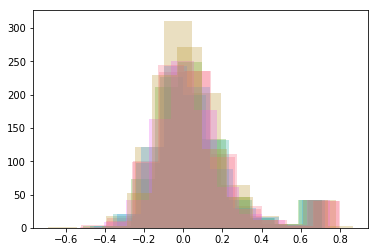

In [195]:
# Run analysis on all ket subjects
#color = sns.cubehelix_palette(len(ket1_corr),8)
#color = sns.palplot(sns.color_palette("RdBu_r", len(ket1_corr)))
sns.set_palette("husl") # set color pallet
correlation_vec = ConnectivityMeasure(kind='partial correlation', vectorize=True) # can choose partial - it might be better
    
# create correlation matrix for each subject
fullVec = []
for time_s in ket3_series:
    cor = correlation_vec.fit_transform([time_s])[0]
    print(cor.shape)
    plt.hist(cor, alpha = 0.3)
    fullVec.append(cor)


In [159]:
# using adjacency matrix - take the real correaltion differences 
# loop through adj matrix
# every time find 1 index it and take actual corelation delts from Ket3-ket1 matrix (or other of that kind)
ket3_ket1.shape
ket3_1 = np.average(ket3_ket1, axis = 0) # make average matrix across subjects
ketDeltaA = []
vector_forReg = []
for adjacent, ket in zip(adj, ket3_1):
    ketDeltaV = []
    # run inner loop within each vector
    for a,i in zip(adjacent, ket):
        
        print(a)
        print(i)
        if a==1:
            ketDeltaV.append(i)
            vector_forReg.append(i)
        else:
            ketDeltaV.append(0)    
    ketDeltaA.append(ketDeltaV)

0.0
0.0
0.0
-0.026404988344048468
0.0
0.015267434252450144
0.0
0.06873683044989634
0.0
0.010476762642713484
0.0
0.001766726869544163
0.0
-0.022158465560854053
0.0
0.004895348596447031
0.0
0.11349769827034549
0.0
0.020314871028919254
0.0
-0.042934881695758986
0.0
0.0161857040095873
0.0
-0.029392030887844436
0.0
-0.026921727266618876
0.0
-0.015897680423944165
0.0
-0.044905855983143575
0.0
-0.0037794979125508484
0.0
-0.006931890853160507
0.0
-0.038643409010109486
0.0
0.025555180685642293
0.0
-0.05717089095666669
0.0
-0.06334034946588482
0.0
0.007773306862765565
1.0
-0.05799199741157222
0.0
0.0789369068725529
0.0
-0.0552605870114919
0.0
0.0016291241941662517
0.0
0.01495674853221472
0.0
-0.017170559072935118
0.0
0.055894790647536254
0.0
-0.0074342163066529
1.0
-0.07020212570798012
0.0
0.08033289446021295
0.0
-0.026378541909939733
0.0
0.04081304427748794
0.0
-0.0405392843319944
0.0
0.04287073115161085
0.0
0.02584031249231112
0.0
-0.05938670099723885
0.0
-0.026404988344048565
0.0
0.0
0.0
-0.0

-0.007721555855106591
0.0
-0.021489646556989563
1.0
-0.1412448347007693
0.0
-0.0007531323602817871
0.0
0.04497614950817802
1.0
0.17538698556511412
0.0
-0.02114740726675326
0.0
-0.02127914780154766
0.0
0.04962078457084136
0.0
-0.17025215174946484
0.0
-0.08954927227932552
0.0
0.014551845336157433
0.0
0.004860144241633528
0.0
0.08484127911678785
0.0
0.07893690687255299
0.0
-0.05624971352993032
0.0
0.026366349451446894
0.0
-0.11857852385021445
0.0
0.026728469589668638
1.0
-0.09428367293064711
1.0
0.12944658438671325
0.0
-0.02176366349547113
0.0
0.05046497235091772
0.0
-0.004195213058834055
0.0
-0.09015728214894833
0.0
0.013202073189563034
0.0
-0.023735375795138416
0.0
0.03520551849236392
0.0
-0.03142556771441816
0.0
0.014287325447796916
0.0
-0.023371132517999518
0.0
0.003837782289753124
0.0
0.022919874880423644
0.0
-0.008498831691203353
0.0
-0.026606465901385053
0.0
-0.02594168713355602
0.0
0.035491485068616296
0.0
0.008363690918071726
0.0
0.0
0.0
0.09706447482059843
1.0
-0.107024306022451

In [169]:
plt.figure(figsize=(80,80))
plotting.plot_connectome(np.array(ketDeltaA), coords,
                        edge_threshold="99%", colorbar=True, output_file="Ket3_vsKet1.png")
plotting.show()

<Figure size 5760x5760 with 0 Axes>

In [130]:
# need to build regression model according to this vector for each subject


array([-0.057992  , -0.07020213, -0.12381693,  0.11467966, -0.10529717,
        0.12839864,  0.12399872,  0.15695406,  0.10526911, -0.09428367,
        0.12944658, -0.08764306, -0.13151992, -0.12381693,  0.0786878 ,
       -0.15258756,  0.11467966, -0.15067737,  0.15695406, -0.1041474 ,
        0.12442553,  0.13251953,  0.08588813,  0.11136084, -0.08106665,
        0.10526911,  0.14933982,  0.0862173 ,  0.08588813, -0.1041474 ,
        0.13251953, -0.10529717,  0.09615918, -0.06307098,  0.11239745,
        0.09516443, -0.057992  ,  0.12839864, -0.14124483,  0.17538699,
       -0.09428367,  0.12944658, -0.10702431, -0.15945332, -0.08764306,
        0.09615918, -0.16275309, -0.10702431, -0.11601474,  0.09745361,
       -0.14124483, -0.15323394,  0.0786878 ,  0.0862173 ,  0.09516443,
        0.12556736,  0.17538699, -0.11601474, -0.15323394, -0.07020213,
        0.11136084, -0.13151992, -0.08106665,  0.09745361,  0.13982135,
       -0.15258756,  0.11239745,  0.12442553, -0.15945332,  0.13

In [171]:
# lets run regression model to try and predict PCL scores with connectivity vector
# first load up pcl data


In [173]:
np.savetxt("coords.txt", coords)